In [27]:
import numpy as np
import random
import sklearn.utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import math
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
import matplotlib.pyplot as plt;

import numpy as np
import matplotlib.pyplot as plt


In [2]:
def flip(classified_sample):
    if classified_sample == 1:
        classified_sample = 0
    else:
        classified_sample = 1
    return classified_sample

In [3]:
n_training_samples = 7500
num_iterations = 1000
num_samples = 300
misclassification_prob1=0.5
misclassification_prob2=0.1
test_class = []
for i in range(0,n_training_samples):
    test_class.append(random.randrange(0,2,1))

test_class = np.array(test_class)


In [4]:
def get_results(sample_classifier1, sample_classifier2, sample_true_class):
    n01 = 0
    n10 = 0
    n00 = 0
    n11 = 0

    for i in range(0, len(sample_classifier1)):
        if (sample_true_class[i] == sample_classifier1[i]) and (sample_true_class[i] != sample_classifier2[i]):
            n01 = n01 + 1
        if ((sample_true_class[i] == sample_classifier2[i]) and sample_true_class[i] != sample_classifier1[i]):
            n10 = n10 + 1
        if (sample_true_class[i] != sample_classifier1[i]) and (sample_true_class[i] != sample_classifier2[i]):
            n00 = n00 + 1
        if (sample_true_class[i] == sample_classifier1[i]) and (sample_true_class[i] == sample_classifier2[i]):
            n11 = n11 + 1
    return n01, n10, n00, n11

def sample_dataset_classes(test_class, num_samples):
    sample_true_class = []
    for j in range(0, num_samples):
        index = random.randrange(0, 7500, 1)
        sample_true_class.append(test_class[index])
    return np.array(sample_true_class)


def sample_classifiers(sample_true_class, min, max):
    sample_classifier1 = []
    sample_classifier2 = []
    for j in range(0, int(num_samples / 2)):
        sample_classifier1.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob1 else flip(
            sample_true_class[j]))
        sample_classifier2.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob2 else flip(
            sample_true_class[j]))
    for j in range(int(num_samples / 2), num_samples):
        sample_classifier1.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob2 else flip(
            sample_true_class[j]))
        sample_classifier2.append(sample_true_class[j] if (random.uniform(0, 1) + random.uniform(min,
                                                                                                 max)) > misclassification_prob1 else flip(
            sample_true_class[j]))

    return np.array(sample_classifier1), np.array(sample_classifier2)


In [21]:
def mc_nemar(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    train, test, train_indices, test_indices = train_test_split(sample_true_class, np.arange(num_samples),
                                                                test_size=0.3)
    n01, n10, n00, n11 = get_results(sample_classifier1[test_indices], sample_classifier2[test_indices],
                                     sample_true_class[test_indices])
    mcnemar = ((abs(n01 - n10) - 1) ** 2) / (n01 + n10)
    if (mcnemar > border_value):
        return True
    else:
        return False

#test for difference of two proportions 1.96 z statistic
def pair_z(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    train, test, train_indices, test_indices = train_test_split(sample_true_class, np.arange(num_samples),
                                                                test_size=0.3)
    n01, n10, n00, n11 = get_results(sample_classifier1[test_indices], sample_classifier2[test_indices],
                                     sample_true_class[test_indices])
    pA = (n00 + n01) / (len(test_indices))
    pB = (n00 + n10) / (len(test_indices))
    p = (pA + pB) / 2
    Z = (pA - pB) / math.sqrt((2 * p * (1 - p)) / (len(test_indices)))
    if (abs(Z) > border_value):
        return True
    else:
        return False

#t statistics, 29 stupnjeva slobode, 2.04523
def resampled_t_test(sample_true_class, border_value):
    p_a = []
    p_b = []
    for i in range(0, 30):
        train, test, train_indices, test_indices = train_test_split(sample_true_class, np.arange(num_samples),
                                                                    test_size=0.3)
        sample_classifier1, sample_classifier2 = sample_classifiers(sample_true_class, 0, 0)
        n01, n10, n00, n11 = get_results(sample_classifier1[test_indices], sample_classifier2[test_indices],
                                         sample_true_class[test_indices])
        p_a.append((n00 + n01) / (len(test_indices)))
        p_b.append((n00 + n10) / (len(test_indices)))
    result = stats.ttest_ind(p_a, p_b)
    if (abs(result[0]) > border_value):
        return True
    else:
        return False

#kfold t test
def kfold_t_test(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    p_a = []
    p_b = []
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    kf.get_n_splits(sample_classifier1)
    for train_index, test_index in kf.split(sample_true_class, sample_true_class):
        n01, n10, n00, n11 = get_results(sample_classifier1[test_index], sample_classifier2[test_index],
                                         sample_true_class[test_index])
        p_a.append((n00 + n01) / (len(test_index)))
        p_b.append((n00 + n10) / (len(test_index)))
    result = stats.ttest_ind(p_a, p_b)
    if (abs(result[0]) > border_value):
        return True
    else:
        return False

#5x2cv test 2.776 mora biti da bi bilo signifikantno
def t_test5x2cv(sample_true_class, sample_classifier1, sample_classifier2, border_value):
    variance = []
    kf = KFold(n_splits=2, shuffle=True)
    kf.get_n_splits(sample_classifier1)
    for i in range(0, 5):
        fold = 0
        counter = 0
        p_1 = 0
        p_2 = 0

        for train_index, test_index in kf.split(sample_classifier1):
            n01, n10, n00, n11 = get_results(sample_classifier1[test_index], sample_classifier2[test_index],
                                             sample_true_class[test_index])
            pA = (n00 + n01) / (len(test_index))
            pB = (n00 + n10) / (len(test_index))
            fold = fold + 1
            if (counter == 0):
                p_1 = pA - pB
            if (counter == 1):
                p_2 = pA - pB
            counter = counter + 1
        p_error = (p_1 + p_2) / 2
        variance.append(((p_1 - p_error) ** 2) + ((p_2 - p_error) ** 2))

    T = p_1 / (math.sqrt(np.mean(np.array(variance))))
    if (abs(T) > border_value):
        return True
    else:
        return False


In [23]:
mc_nemar_errors = 0
pair_z_errors = 0
resampled_t_errors = 0
kfold_t_errors = 0
t_test5x2_errors = 0

for i in range(0, 1000):
    print("Calculating iteration " + str(i))
    sample_true_class = sample_dataset_classes(test_class, num_samples)
    sample_classifier1, sample_classifier2 = sample_classifiers(sample_true_class, -0.02, 0.02)
    n01, n10, n00, n11 = get_results(sample_classifier1, sample_classifier2, sample_true_class)
    if (mc_nemar(sample_true_class, sample_classifier1, sample_classifier2, 3.841)):
        mc_nemar_errors += 1
    if (pair_z(sample_true_class, sample_classifier1, sample_classifier2, 1.96)):
        pair_z_errors += 1
    if (resampled_t_test(sample_true_class, 2.04523)):
        resampled_t_errors += 1
    if (kfold_t_test(sample_true_class, sample_classifier1, sample_classifier2, 2.262)):
        kfold_t_errors += 1
    if (t_test5x2cv(sample_true_class, sample_classifier1, sample_classifier2, 2.571)):
        t_test5x2_errors += 1


Calculating iteration 0
Calculating iteration 1
Calculating iteration 2


Calculating iteration 3
Calculating iteration 4
Calculating iteration 5


Calculating iteration 6
Calculating iteration 7
Calculating iteration 8


Calculating iteration 9
Calculating iteration 10
Calculating iteration 11


Calculating iteration 12
Calculating iteration 13
Calculating iteration 14


Calculating iteration 15
Calculating iteration 16
Calculating iteration 17


Calculating iteration 18
Calculating iteration 19
Calculating iteration 20


Calculating iteration 21
Calculating iteration 22
Calculating iteration 23


Calculating iteration 24
Calculating iteration 25
Calculating iteration 26
Calculating iteration 27


Calculating iteration 28
Calculating iteration 29


Calculating iteration 30
Calculating iteration 31


Calculating iteration 32
Calculating iteration 33
Calculating iteration 34


Calculating iteration 35
Calculating iteration 36
Calculating iteration 37


Calculating iteration 38
Calculating iteration 39
Calculating iteration 40
Calculating iteration 41


Calculating iteration 42
Calculating iteration 43


Calculating iteration 44
Calculating iteration 45
Calculating iteration 46


Calculating iteration 47
Calculating iteration 48
Calculating iteration 49


Calculating iteration 50
Calculating iteration 51
Calculating iteration 52


Calculating iteration 53
Calculating iteration 54
Calculating iteration 55


Calculating iteration 56
Calculating iteration 57
Calculating iteration 58
Calculating iteration 59


Calculating iteration 60
Calculating iteration 61
Calculating iteration 62


Calculating iteration 63
Calculating iteration 64
Calculating iteration 65


Calculating iteration 66
Calculating iteration 67
Calculating iteration 68


Calculating iteration 69
Calculating iteration 70
Calculating iteration 71


Calculating iteration 72
Calculating iteration 73
Calculating iteration 74


Calculating iteration 75
Calculating iteration 76
Calculating iteration 77


Calculating iteration 78
Calculating iteration 79
Calculating iteration 80
Calculating iteration 81


Calculating iteration 82
Calculating iteration 83
Calculating iteration 84
Calculating iteration 85


Calculating iteration 86
Calculating iteration 87
Calculating iteration 88


Calculating iteration 89
Calculating iteration 90


Calculating iteration 91
Calculating iteration 92
Calculating iteration 93
Calculating iteration 94


Calculating iteration 95
Calculating iteration 96
Calculating iteration 97


Calculating iteration 98
Calculating iteration 99
Calculating iteration 100


Calculating iteration 101
Calculating iteration 102
Calculating iteration 103
Calculating iteration 104


Calculating iteration 105
Calculating iteration 106
Calculating iteration 107
Calculating iteration 108
Calculating iteration 109


Calculating iteration 110
Calculating iteration 111
Calculating iteration 112
Calculating iteration 113
Calculating iteration 114


Calculating iteration 115
Calculating iteration 116
Calculating iteration 117
Calculating iteration 118
Calculating iteration 119


Calculating iteration 120
Calculating iteration 121
Calculating iteration 122
Calculating iteration 123
Calculating iteration 124


Calculating iteration 125
Calculating iteration 126
Calculating iteration 127
Calculating iteration 128
Calculating iteration 129


Calculating iteration 130
Calculating iteration 131
Calculating iteration 132
Calculating iteration 133
Calculating iteration 134


Calculating iteration 135
Calculating iteration 136
Calculating iteration 137
Calculating iteration 138
Calculating iteration 139


Calculating iteration 140
Calculating iteration 141
Calculating iteration 142
Calculating iteration 143
Calculating iteration 144


Calculating iteration 145
Calculating iteration 146
Calculating iteration 147
Calculating iteration 148
Calculating iteration 149


Calculating iteration 150
Calculating iteration 151
Calculating iteration 152
Calculating iteration 153
Calculating iteration 154


Calculating iteration 155
Calculating iteration 156
Calculating iteration 157
Calculating iteration 158
Calculating iteration 159


Calculating iteration 160
Calculating iteration 161
Calculating iteration 162
Calculating iteration 163
Calculating iteration 164


Calculating iteration 165
Calculating iteration 166
Calculating iteration 167
Calculating iteration 168
Calculating iteration 169


Calculating iteration 170
Calculating iteration 171
Calculating iteration 172
Calculating iteration 173
Calculating iteration 174


Calculating iteration 175
Calculating iteration 176
Calculating iteration 177
Calculating iteration 178


Calculating iteration 179
Calculating iteration 180
Calculating iteration 181
Calculating iteration 182


Calculating iteration 183
Calculating iteration 184
Calculating iteration 185
Calculating iteration 186


Calculating iteration 187
Calculating iteration 188
Calculating iteration 189
Calculating iteration 190
Calculating iteration 191


Calculating iteration 192
Calculating iteration 193
Calculating iteration 194
Calculating iteration 195


Calculating iteration 196
Calculating iteration 197
Calculating iteration 198
Calculating iteration 199


Calculating iteration 200
Calculating iteration 201
Calculating iteration 202
Calculating iteration 203


Calculating iteration 204
Calculating iteration 205
Calculating iteration 206
Calculating iteration 207


Calculating iteration 208
Calculating iteration 209
Calculating iteration 210
Calculating iteration 211


Calculating iteration 212
Calculating iteration 213
Calculating iteration 214
Calculating iteration 215


Calculating iteration 216
Calculating iteration 217
Calculating iteration 218
Calculating iteration 219


Calculating iteration 220
Calculating iteration 221
Calculating iteration 222
Calculating iteration 223
Calculating iteration 224


Calculating iteration 225
Calculating iteration 226
Calculating iteration 227
Calculating iteration 228
Calculating iteration 229


Calculating iteration 230
Calculating iteration 231
Calculating iteration 232
Calculating iteration 233
Calculating iteration 234


Calculating iteration 235
Calculating iteration 236
Calculating iteration 237
Calculating iteration 238
Calculating iteration 239


Calculating iteration 240
Calculating iteration 241
Calculating iteration 242
Calculating iteration 243
Calculating iteration 244


Calculating iteration 245
Calculating iteration 246
Calculating iteration 247
Calculating iteration 248


Calculating iteration 249
Calculating iteration 250
Calculating iteration 251
Calculating iteration 252
Calculating iteration 253


Calculating iteration 254
Calculating iteration 255
Calculating iteration 256
Calculating iteration 257
Calculating iteration 258


Calculating iteration 259
Calculating iteration 260
Calculating iteration 261
Calculating iteration 262


Calculating iteration 263
Calculating iteration 264
Calculating iteration 265


Calculating iteration 266
Calculating iteration 267
Calculating iteration 268
Calculating iteration 269
Calculating iteration 270


Calculating iteration 271
Calculating iteration 272
Calculating iteration 273


Calculating iteration 274
Calculating iteration 275
Calculating iteration 276
Calculating iteration 277
Calculating iteration 278


Calculating iteration 279
Calculating iteration 280
Calculating iteration 281
Calculating iteration 282


Calculating iteration 283
Calculating iteration 284
Calculating iteration 285
Calculating iteration 286
Calculating iteration 287


Calculating iteration 288
Calculating iteration 289
Calculating iteration 290
Calculating iteration 291
Calculating iteration 292


Calculating iteration 293
Calculating iteration 294
Calculating iteration 295
Calculating iteration 296
Calculating iteration 297


Calculating iteration 298
Calculating iteration 299
Calculating iteration 300
Calculating iteration 301
Calculating iteration 302


Calculating iteration 303
Calculating iteration 304
Calculating iteration 305
Calculating iteration 306
Calculating iteration 307


Calculating iteration 308
Calculating iteration 309
Calculating iteration 310
Calculating iteration 311
Calculating iteration 312


Calculating iteration 313
Calculating iteration 314
Calculating iteration 315
Calculating iteration 316
Calculating iteration 317


Calculating iteration 318
Calculating iteration 319
Calculating iteration 320
Calculating iteration 321


Calculating iteration 322
Calculating iteration 323
Calculating iteration 324


Calculating iteration 325
Calculating iteration 326
Calculating iteration 327
Calculating iteration 328
Calculating iteration 329


Calculating iteration 330
Calculating iteration 331
Calculating iteration 332
Calculating iteration 333
Calculating iteration 334


Calculating iteration 335
Calculating iteration 336
Calculating iteration 337
Calculating iteration 338
Calculating iteration 339


Calculating iteration 340
Calculating iteration 341
Calculating iteration 342
Calculating iteration 343
Calculating iteration 344


Calculating iteration 345
Calculating iteration 346
Calculating iteration 347
Calculating iteration 348
Calculating iteration 349


Calculating iteration 350
Calculating iteration 351
Calculating iteration 352
Calculating iteration 353
Calculating iteration 354


Calculating iteration 355
Calculating iteration 356
Calculating iteration 357
Calculating iteration 358
Calculating iteration 359


Calculating iteration 360
Calculating iteration 361
Calculating iteration 362
Calculating iteration 363
Calculating iteration 364


Calculating iteration 365
Calculating iteration 366
Calculating iteration 367
Calculating iteration 368
Calculating iteration 369


Calculating iteration 370
Calculating iteration 371
Calculating iteration 372
Calculating iteration 373
Calculating iteration 374


Calculating iteration 375
Calculating iteration 376
Calculating iteration 377
Calculating iteration 378
Calculating iteration 379


Calculating iteration 380
Calculating iteration 381
Calculating iteration 382
Calculating iteration 383


Calculating iteration 384
Calculating iteration 385
Calculating iteration 386
Calculating iteration 387
Calculating iteration 388


Calculating iteration 389
Calculating iteration 390
Calculating iteration 391
Calculating iteration 392
Calculating iteration 393


Calculating iteration 394
Calculating iteration 395
Calculating iteration 396
Calculating iteration 397
Calculating iteration 398


Calculating iteration 399
Calculating iteration 400
Calculating iteration 401
Calculating iteration 402
Calculating iteration 403


Calculating iteration 404
Calculating iteration 405
Calculating iteration 406
Calculating iteration 407
Calculating iteration 408


Calculating iteration 409
Calculating iteration 410
Calculating iteration 411
Calculating iteration 412


Calculating iteration 413
Calculating iteration 414
Calculating iteration 415
Calculating iteration 416


Calculating iteration 417
Calculating iteration 418
Calculating iteration 419
Calculating iteration 420
Calculating iteration 421


Calculating iteration 422
Calculating iteration 423
Calculating iteration 424
Calculating iteration 425
Calculating iteration 426


Calculating iteration 427
Calculating iteration 428
Calculating iteration 429
Calculating iteration 430
Calculating iteration 431


Calculating iteration 432
Calculating iteration 433
Calculating iteration 434
Calculating iteration 435
Calculating iteration 436


Calculating iteration 437
Calculating iteration 438
Calculating iteration 439
Calculating iteration 440


Calculating iteration 441
Calculating iteration 442
Calculating iteration 443
Calculating iteration 444
Calculating iteration 445


Calculating iteration 446
Calculating iteration 447
Calculating iteration 448
Calculating iteration 449


Calculating iteration 450
Calculating iteration 451
Calculating iteration 452
Calculating iteration 453
Calculating iteration 454


Calculating iteration 455
Calculating iteration 456
Calculating iteration 457
Calculating iteration 458
Calculating iteration 459


Calculating iteration 460
Calculating iteration 461
Calculating iteration 462
Calculating iteration 463
Calculating iteration 464


Calculating iteration 465
Calculating iteration 466
Calculating iteration 467
Calculating iteration 468
Calculating iteration 469


Calculating iteration 470
Calculating iteration 471
Calculating iteration 472
Calculating iteration 473
Calculating iteration 474


Calculating iteration 475
Calculating iteration 476
Calculating iteration 477
Calculating iteration 478
Calculating iteration 479


Calculating iteration 480
Calculating iteration 481
Calculating iteration 482
Calculating iteration 483
Calculating iteration 484


Calculating iteration 485
Calculating iteration 486
Calculating iteration 487
Calculating iteration 488


Calculating iteration 489
Calculating iteration 490
Calculating iteration 491
Calculating iteration 492
Calculating iteration 493


Calculating iteration 494
Calculating iteration 495
Calculating iteration 496
Calculating iteration 497
Calculating iteration 498


Calculating iteration 499
Calculating iteration 500
Calculating iteration 501
Calculating iteration 502
Calculating iteration 503


Calculating iteration 504
Calculating iteration 505
Calculating iteration 506
Calculating iteration 507
Calculating iteration 508


Calculating iteration 509
Calculating iteration 510
Calculating iteration 511
Calculating iteration 512
Calculating iteration 513


Calculating iteration 514
Calculating iteration 515
Calculating iteration 516
Calculating iteration 517
Calculating iteration 518


Calculating iteration 519
Calculating iteration 520
Calculating iteration 521
Calculating iteration 522
Calculating iteration 523


Calculating iteration 524
Calculating iteration 525
Calculating iteration 526
Calculating iteration 527


Calculating iteration 528
Calculating iteration 529
Calculating iteration 530
Calculating iteration 531
Calculating iteration 532


Calculating iteration 533
Calculating iteration 534
Calculating iteration 535
Calculating iteration 536
Calculating iteration 537


Calculating iteration 538
Calculating iteration 539
Calculating iteration 540
Calculating iteration 541
Calculating iteration 542


Calculating iteration 543
Calculating iteration 544
Calculating iteration 545
Calculating iteration 546


Calculating iteration 547
Calculating iteration 548
Calculating iteration 549
Calculating iteration 550


Calculating iteration 551
Calculating iteration 552
Calculating iteration 553
Calculating iteration 554
Calculating iteration 555


Calculating iteration 556
Calculating iteration 557
Calculating iteration 558
Calculating iteration 559
Calculating iteration 560


Calculating iteration 561
Calculating iteration 562
Calculating iteration 563
Calculating iteration 564
Calculating iteration 565


Calculating iteration 566
Calculating iteration 567
Calculating iteration 568
Calculating iteration 569


Calculating iteration 570
Calculating iteration 571
Calculating iteration 572
Calculating iteration 573


Calculating iteration 574
Calculating iteration 575
Calculating iteration 576
Calculating iteration 577
Calculating iteration 578


Calculating iteration 579
Calculating iteration 580
Calculating iteration 581
Calculating iteration 582
Calculating iteration 583


Calculating iteration 584
Calculating iteration 585
Calculating iteration 586
Calculating iteration 587
Calculating iteration 588


Calculating iteration 589
Calculating iteration 590
Calculating iteration 591
Calculating iteration 592
Calculating iteration 593


Calculating iteration 594
Calculating iteration 595
Calculating iteration 596
Calculating iteration 597
Calculating iteration 598


Calculating iteration 599
Calculating iteration 600
Calculating iteration 601
Calculating iteration 602


Calculating iteration 603
Calculating iteration 604
Calculating iteration 605
Calculating iteration 606
Calculating iteration 607


Calculating iteration 608
Calculating iteration 609
Calculating iteration 610
Calculating iteration 611


Calculating iteration 612
Calculating iteration 613
Calculating iteration 614
Calculating iteration 615


Calculating iteration 616
Calculating iteration 617
Calculating iteration 618
Calculating iteration 619


Calculating iteration 620
Calculating iteration 621
Calculating iteration 622
Calculating iteration 623


Calculating iteration 624
Calculating iteration 625
Calculating iteration 626
Calculating iteration 627
Calculating iteration 628


Calculating iteration 629
Calculating iteration 630
Calculating iteration 631
Calculating iteration 632
Calculating iteration 633


Calculating iteration 634
Calculating iteration 635
Calculating iteration 636
Calculating iteration 637


Calculating iteration 638
Calculating iteration 639
Calculating iteration 640
Calculating iteration 641
Calculating iteration 642


Calculating iteration 643
Calculating iteration 644
Calculating iteration 645
Calculating iteration 646
Calculating iteration 647


Calculating iteration 648
Calculating iteration 649
Calculating iteration 650
Calculating iteration 651
Calculating iteration 652


Calculating iteration 653
Calculating iteration 654
Calculating iteration 655
Calculating iteration 656


Calculating iteration 657
Calculating iteration 658
Calculating iteration 659
Calculating iteration 660


Calculating iteration 661
Calculating iteration 662
Calculating iteration 663
Calculating iteration 664


Calculating iteration 665
Calculating iteration 666
Calculating iteration 667
Calculating iteration 668


Calculating iteration 669
Calculating iteration 670
Calculating iteration 671
Calculating iteration 672
Calculating iteration 673


Calculating iteration 674
Calculating iteration 675
Calculating iteration 676
Calculating iteration 677
Calculating iteration 678


Calculating iteration 679
Calculating iteration 680
Calculating iteration 681
Calculating iteration 682
Calculating iteration 683


Calculating iteration 684
Calculating iteration 685
Calculating iteration 686
Calculating iteration 687
Calculating iteration 688


Calculating iteration 689
Calculating iteration 690
Calculating iteration 691
Calculating iteration 692
Calculating iteration 693


Calculating iteration 694
Calculating iteration 695
Calculating iteration 696
Calculating iteration 697
Calculating iteration 698


Calculating iteration 699
Calculating iteration 700
Calculating iteration 701
Calculating iteration 702
Calculating iteration 703


Calculating iteration 704
Calculating iteration 705
Calculating iteration 706
Calculating iteration 707
Calculating iteration 708


Calculating iteration 709
Calculating iteration 710
Calculating iteration 711
Calculating iteration 712
Calculating iteration 713


Calculating iteration 714
Calculating iteration 715
Calculating iteration 716
Calculating iteration 717
Calculating iteration 718


Calculating iteration 719
Calculating iteration 720
Calculating iteration 721
Calculating iteration 722
Calculating iteration 723


Calculating iteration 724
Calculating iteration 725
Calculating iteration 726
Calculating iteration 727
Calculating iteration 728


Calculating iteration 729
Calculating iteration 730
Calculating iteration 731
Calculating iteration 732


Calculating iteration 733
Calculating iteration 734
Calculating iteration 735
Calculating iteration 736
Calculating iteration 737


Calculating iteration 738
Calculating iteration 739
Calculating iteration 740
Calculating iteration 741
Calculating iteration 742


Calculating iteration 743
Calculating iteration 744
Calculating iteration 745
Calculating iteration 746
Calculating iteration 747


Calculating iteration 748
Calculating iteration 749
Calculating iteration 750
Calculating iteration 751
Calculating iteration 752


Calculating iteration 753
Calculating iteration 754
Calculating iteration 755
Calculating iteration 756
Calculating iteration 757


Calculating iteration 758
Calculating iteration 759
Calculating iteration 760
Calculating iteration 761


Calculating iteration 762
Calculating iteration 763
Calculating iteration 764
Calculating iteration 765
Calculating iteration 766


Calculating iteration 767
Calculating iteration 768
Calculating iteration 769
Calculating iteration 770
Calculating iteration 771


Calculating iteration 772
Calculating iteration 773
Calculating iteration 774
Calculating iteration 775
Calculating iteration 776


Calculating iteration 777
Calculating iteration 778
Calculating iteration 779
Calculating iteration 780
Calculating iteration 781


Calculating iteration 782
Calculating iteration 783
Calculating iteration 784
Calculating iteration 785
Calculating iteration 786


Calculating iteration 787
Calculating iteration 788
Calculating iteration 789
Calculating iteration 790


Calculating iteration 791
Calculating iteration 792
Calculating iteration 793
Calculating iteration 794
Calculating iteration 795
Calculating iteration 796


Calculating iteration 797
Calculating iteration 798
Calculating iteration 799
Calculating iteration 800
Calculating iteration 801


Calculating iteration 802
Calculating iteration 803
Calculating iteration 804
Calculating iteration 805
Calculating iteration 806


Calculating iteration 807
Calculating iteration 808
Calculating iteration 809
Calculating iteration 810
Calculating iteration 811


Calculating iteration 812
Calculating iteration 813
Calculating iteration 814
Calculating iteration 815
Calculating iteration 816


Calculating iteration 817
Calculating iteration 818
Calculating iteration 819
Calculating iteration 820


Calculating iteration 821
Calculating iteration 822
Calculating iteration 823
Calculating iteration 824
Calculating iteration 825


Calculating iteration 826
Calculating iteration 827
Calculating iteration 828
Calculating iteration 829
Calculating iteration 830


Calculating iteration 831
Calculating iteration 832
Calculating iteration 833
Calculating iteration 834
Calculating iteration 835


Calculating iteration 836
Calculating iteration 837
Calculating iteration 838


Calculating iteration 839
Calculating iteration 840
Calculating iteration 841
Calculating iteration 842
Calculating iteration 843


Calculating iteration 844
Calculating iteration 845
Calculating iteration 846
Calculating iteration 847
Calculating iteration 848


Calculating iteration 849
Calculating iteration 850
Calculating iteration 851
Calculating iteration 852
Calculating iteration 853


Calculating iteration 854
Calculating iteration 855
Calculating iteration 856
Calculating iteration 857
Calculating iteration 858


Calculating iteration 859
Calculating iteration 860
Calculating iteration 861
Calculating iteration 862


Calculating iteration 863
Calculating iteration 864
Calculating iteration 865
Calculating iteration 866


Calculating iteration 867
Calculating iteration 868
Calculating iteration 869
Calculating iteration 870


Calculating iteration 871
Calculating iteration 872
Calculating iteration 873
Calculating iteration 874
Calculating iteration 875


Calculating iteration 876
Calculating iteration 877
Calculating iteration 878
Calculating iteration 879


Calculating iteration 880
Calculating iteration 881
Calculating iteration 882
Calculating iteration 883


Calculating iteration 884
Calculating iteration 885
Calculating iteration 886
Calculating iteration 887


Calculating iteration 888
Calculating iteration 889
Calculating iteration 890
Calculating iteration 891
Calculating iteration 892


Calculating iteration 893
Calculating iteration 894
Calculating iteration 895
Calculating iteration 896


Calculating iteration 897
Calculating iteration 898
Calculating iteration 899
Calculating iteration 900
Calculating iteration 901


Calculating iteration 902
Calculating iteration 903
Calculating iteration 904
Calculating iteration 905
Calculating iteration 906


Calculating iteration 907
Calculating iteration 908
Calculating iteration 909
Calculating iteration 910
Calculating iteration 911


Calculating iteration 912
Calculating iteration 913
Calculating iteration 914
Calculating iteration 915


Calculating iteration 916
Calculating iteration 917
Calculating iteration 918
Calculating iteration 919
Calculating iteration 920


Calculating iteration 921
Calculating iteration 922
Calculating iteration 923
Calculating iteration 924
Calculating iteration 925


Calculating iteration 926
Calculating iteration 927
Calculating iteration 928
Calculating iteration 929


Calculating iteration 930
Calculating iteration 931
Calculating iteration 932
Calculating iteration 933


Calculating iteration 934
Calculating iteration 935
Calculating iteration 936
Calculating iteration 937


Calculating iteration 938
Calculating iteration 939
Calculating iteration 940
Calculating iteration 941


Calculating iteration 942
Calculating iteration 943
Calculating iteration 944
Calculating iteration 945


Calculating iteration 946
Calculating iteration 947
Calculating iteration 948


Calculating iteration 949
Calculating iteration 950
Calculating iteration 951


Calculating iteration 952
Calculating iteration 953
Calculating iteration 954
Calculating iteration 955


Calculating iteration 956
Calculating iteration 957
Calculating iteration 958
Calculating iteration 959
Calculating iteration 960


Calculating iteration 961
Calculating iteration 962
Calculating iteration 963
Calculating iteration 964


Calculating iteration 965
Calculating iteration 966
Calculating iteration 967
Calculating iteration 968


Calculating iteration 969
Calculating iteration 970
Calculating iteration 971
Calculating iteration 972
Calculating iteration 973


Calculating iteration 974
Calculating iteration 975
Calculating iteration 976
Calculating iteration 977
Calculating iteration 978


Calculating iteration 979
Calculating iteration 980
Calculating iteration 981
Calculating iteration 982
Calculating iteration 983


Calculating iteration 984
Calculating iteration 985
Calculating iteration 986
Calculating iteration 987
Calculating iteration 988


Calculating iteration 989
Calculating iteration 990
Calculating iteration 991
Calculating iteration 992
Calculating iteration 993


Calculating iteration 994
Calculating iteration 995
Calculating iteration 996
Calculating iteration 997
Calculating iteration 998


Calculating iteration 999


In [ ]:
print(mc_nemar_errors)
print(pair_z_errors)
print(resampled_t_errors)
print(kfold_t_errors)
print(t_test5x2_errors)


30
58
64
21
14


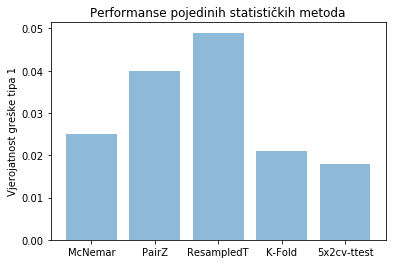

In [26]:
objects = ('McNemar', 'PairZ', 'ResampledT', 'K-Fold', '5x2cv-ttest')
y_pos = np.arange(len(objects))
performance = [mc_nemar_errors/1000,pair_z_errors/1000,resampled_t_errors/1000,kfold_t_errors/1000,t_test5x2_errors/1000]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Vjerojatnost greške tipa 1')
plt.title('Performanse pojedinih statističkih metoda')
plt.savefig("rezultati.png")
plt.show()

